In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import pathlib
import PIL
import datetime

In [2]:
# Connect if you are running the notebook on Google Colaboratory and the dataset is on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path for Google Colab (alter it accoring to your folder structure, if running on colaboratory)

dataset_dir = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Datasets/dataset2-master/dataset2-master/images"
# dataset_dir = os.path.join("..", "Datasets", "dataset2-master", "dataset2-master", "images")
training_dir = os.path.join(dataset_dir, "TRAIN")
testing_dir = os.path.join(dataset_dir, "TEST")
simple_test_dir = os.path.join(dataset_dir, "TEST_SIMPLE")

In [4]:
training = pathlib.Path(training_dir)
testing = pathlib.Path(testing_dir)
simple_testing = pathlib.Path(simple_test_dir)
training_images_count = len(list(training.glob("*/*.jpeg")))
testing_images_count = len(list(testing.glob("*/*.jpeg")))
simple_test_count = len(list(simple_testing.glob("*/*.jpeg")))

print(f"Number of Training Images = {training_images_count}")
print(f"Number of Testing Images = {testing_images_count}")
print(f"Number of Simple Testing Images = {simple_test_count}")


Number of Training Images = 9957
Number of Testing Images = 2487
Number of Simple Testing Images = 71


In [5]:
class_names = os.listdir(training_dir)
class_names

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']

NEUTROPHIL


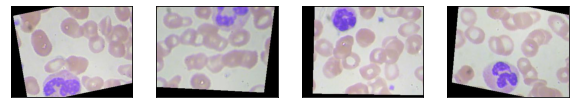

MONOCYTE


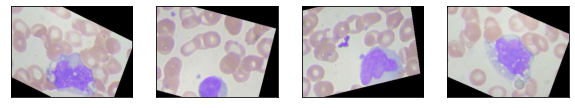

EOSINOPHIL


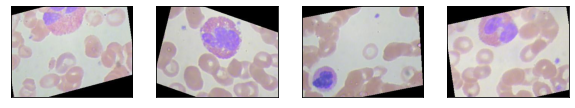

LYMPHOCYTE


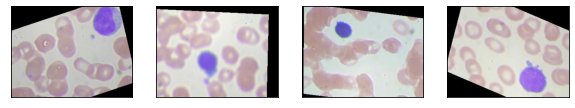

In [6]:
for name in class_names:
    subdir = os.path.join(training_dir, name)
    images = os.listdir(subdir)
    fig = plt.figure(num=name, figsize=(10, 10))
    print(name)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = mpimg.imread(os.path.join(subdir, images[i]))
        plt.imshow(img)
    plt.show()

In [7]:
BATCH_SIZE = 32
temp_img_path = os.path.join(training_dir, "EOSINOPHIL", "_0_207.jpeg")
IMG_HEIGHT = PIL.Image.open(temp_img_path).height
IMG_WIDTH = PIL.Image.open(temp_img_path).width

print(f"Image dimentions = {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Batch Size = {BATCH_SIZE}")

Image dimentions = 320x240
Batch Size = 32


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    labels = "inferred",
    # label_mode = "int",
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 69,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = "rgb"   
)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    labels = "inferred",
    # label_mode = "int",
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 69,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = "rgb"   
)

Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    testing_dir,
    labels="inferred",
    shuffle=True,
    seed = 69,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = "rgb"
)

Found 2487 files belonging to 4 classes.


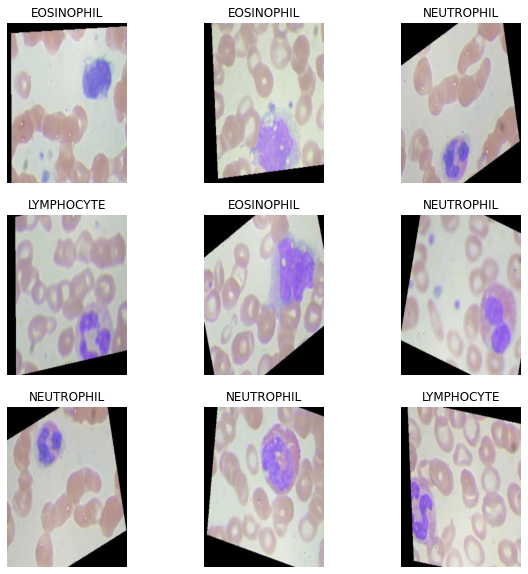

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

## Run with specific parameters at a time

In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.Conv2D(32, 3, padding='same', activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation="relu"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

model.compile(
    optimizer="rmsprop",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Paths for Colaboratory
# dataset_cache_file_path = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/"
# log_file_path = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/logs.txt"
# tensorboard_log_dir = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/"

# Local Paths
dataset_cache_file_path = os.path.join(".", "Runtime", "")
log_file_path = os.path.join(".", "Runtime", "logs.txt")
tensorboard_log_dir = os.path.join(".", "Runtime", "")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache(dataset_cache_file_path).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache(dataset_cache_file_path).prefetch(buffer_size=AUTOTUNE)

In [ ]:
def clearLogFile():
    open(log_file_path, 'w').close()

def callbackLogger(batch, logs):
    with open(log_file_path, "a+") as f:
        f.write(f"Batch - {batch} {logs}\n")

clearLogFile()
basic_info_log_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=callbackLogger)

In [ ]:
%load_ext tensorboard

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir, 
    histogram_freq=1
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    batch_size = BATCH_SIZE,
    callbacks=[basic_info_log_callback, tensorboard_callback]
)

In [ ]:
# To upload logs to TensorBoard
!tensorboard dev upload \
    --logdir "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/" \
    --name "SSOC Blood Disease - {Optimizer: RMSPROP, loss: SCC, activation: adam} " \
    --description "SSOC" \
    --one_shot

### The below code is for trying different optimizers/loss fn/activation fn with a common model architecture and upload the results on tensorboard

In [11]:
def clearLogFile(log_file_path):
    open(log_file_path, 'w').close()

def tensorBoardConfigure(tensorboard_log_dir):
    %load_ext tensorboard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_log_dir, 
        histogram_freq=1
    )

def callbackLogger(batch, logs, log_file_path):
    with open(log_file_path, "a+") as f:
        f.write(f"Batch - {batch} {logs}\n")

def logToTensorboard(log_dir, name, description):
    !tensorboard dev upload \
        --logdir $log_dir \
        --name $name \
        --one_shot \

def setup(dataset_cache_file_path, log_file_path, tensorboard_log_dir):
    global train_ds, val_ds
    AUTOTUNE = tf.data.AUTOTUNE

    
    # cache and prefetch
    train_ds = train_ds.cache(dataset_cache_file_path).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache(dataset_cache_file_path).prefetch(buffer_size=AUTOTUNE)

    # clear log file
    clearLogFile(log_file_path)

    # TensorBoard Configure
    tensorBoardConfigure(tensorboard_log_dir)


In [13]:
def testAndLogModel(optimizer, loss, activationFn, epochs):
    """
        This function trains the model based on the passed parameters and
        logs the details to tensorboard, whose screen shots are in the
        images folder.
    """

    num_classes = len(class_names)
    log_file_path = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/logs.txt"
    dataset_cache_file_path = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/"
    tensorboard_log_dir = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/"
    # dataset_cache_file_path = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/Cache_Prefetch_Data/"
    # tensorboard_log_dir = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/Tensorboard_Logs/"
    log_name = f"SSOC_Blood_Disease__Optimizer:{optimizer}__loss:{loss.name}__activation:{activationFn}"
    
    setup(dataset_cache_file_path, log_file_path, tensorboard_log_dir)
    print(log_name)
    
    # CALLBACKS
    basic_info_log_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch, logs: callbackLogger(batch, logs, log_file_path))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_log_dir+f"{optimizer}_{loss.name}_{activationFn}_"+datetime.datetime.now().strftime("%d_%m_%y %l:%M:%S"), 
        histogram_freq=1
    )

    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        layers.Conv2D(32, 3, padding='same', activation=activationFn),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, padding='same', activation=activationFn),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, padding='same', activation=activationFn),
        layers.MaxPool2D(),
        layers.Conv2D(32, 3, padding='same', activation=activationFn),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(128, activation=activationFn),
        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size = BATCH_SIZE,
        callbacks=[basic_info_log_callback, tensorboard_callback]
    )

    logToTensorboard(tensorboard_log_dir, log_name, "")

    return history

In [39]:
epochs = 15
histories = []

different_parameters = [
    {"optimizer": "sgd", "loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": "relu"},
    {"optimizer": "adagrad", "loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": "relu"},
    {"optimizer": "rmsprop", "loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": "relu"},
    {"optimizer": "adadelta", "loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": "relu"},
    {"optimizer": "adam", "loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": "relu"},
]

for parameters in different_parameters:
    history = testAndLogModel(parameters["optimizer"], parameters["loss"], parameters["activationFn"], epochs)
    print()
    print("~"*150)
    print()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
249/249 [==============================] - 45s 180ms/step - loss: 1.3870 - accuracy: 0.2526 - val_loss: 1.3857 - val_accuracy: 0.2604
Epoch 2/15
249/249 [==============================] - 43s 171ms/step - loss: 1.3855 - accuracy: 0.2580 - val_loss: 1.3844 - val_accuracy: 0.2644
Epoch 3/15
249/249 [==============================] - 43s 174ms/step - loss: 1.3836 - accuracy: 0.2733 - val_loss: 1.3812 - val_accuracy: 0.2842
Epoch 4/15
249/249 [==============================] - 43s 170ms/step - loss: 1.3794 - accuracy: 0.2911 - val_loss: 1.3769 - val_accuracy: 0.2778
Epoch 5/15
249/249 [==============================] - 42s 169ms/step - loss: 1.3711 - accuracy: 0.3099 - val_loss: 1.3718 - val_accuracy: 0.2956
Epoch 6/15
249/249 [==============================] - 44s 175ms/step - loss: 1.3785 - accuracy: 0.2837 - val_loss: 1.3840 - val_accuracy: 0.2550
Epoch 7/15
249/249 [====================